In [17]:
import pandas as pd

In [18]:
data = pd.read_csv("./mathdial/data/test.csv")

In [19]:
conversations = data["conversation"]

In [20]:
strategies = {"probing": 0, "generic": 0, "focus": 0, "telling": 0}
data['strategies'] = ""
data['strategies'] = data['strategies'].astype('object')

for i, line in enumerate(conversations):
    variable_line = line
    min_index = 0

    current_strategies = []
    while variable_line.find("(", min_index) > 0:
        a, b = variable_line.find("(", min_index) + 1, variable_line.find(")", min_index)
        strategy = variable_line[a:b]
        if strategy not in strategies:
            min_index = b + 1
            continue
            
        strategies[strategy] += 1
        current_strategies.append(strategy)
    
        variable_line = variable_line[:a - 1] + variable_line[b + 1:]

    data.at[i, "cut_conversation"] = variable_line
    data.at[i, "strategies"] = current_strategies

In [21]:
strategies

{'probing': 952, 'generic': 890, 'focus': 1259, 'telling': 596}

In [22]:
from matplotlib import pyplot as plt

<BarContainer object of 4 artists>

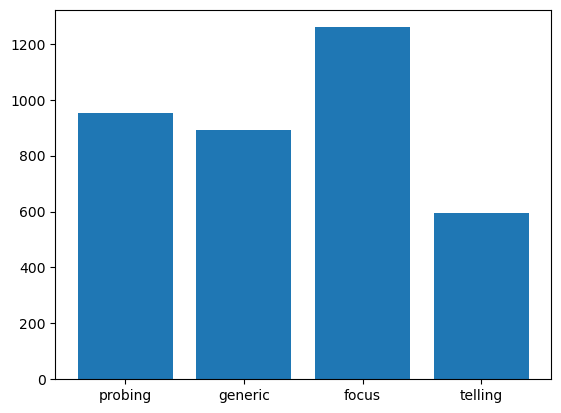

In [23]:
plt.bar(strategies.keys(), strategies.values())

In [24]:
data.head(10)

,qid,scenario,question,ground_truth,student_incorrect_solution,student_profile,teacher_described_confusion,self-correctness,self-typical-confusion,self-typical-interactions,conversation,strategies,cut_conversation
0,6000025,1,Julia was preparing for a dinner party at her ...,The total number of spoons from Julia and her ...,"Let's call the number of spoons Julia bought ""...",Mariana is a 7th grade student. She has diffic...,subtracting instead of adding,Yes,4.0,4.0,"Teacher: (generic)Hi Mariana, please talk me t...","[generic, focus, telling, generic]","Teacher: Hi Mariana, please talk me through yo..."
1,6000044,2,Carmen goes to an auction to win an antique de...,3 other people are bidding on the desk so ther...,The first bid was $200 and each subsequent bid...,Ayisha is a 7th grade student. She struggle to...,miscalculation,"Yes, but I had to reveal the answer",4.0,4.0,"Teacher: (generic)Hi Ayisha, please talk me th...","[generic, focus, focus, telling, focus, tellin...","Teacher: Hi Ayisha, please talk me through you..."
2,6000060,3,"Karan borrowed $3,650 for five months at an in...","Karan's interest is $3,650 × 0.1 = $365.\nIn t...","Karan borrowed $3,650 for 5 months, so the tot...",Scott is a 7th grade student. He struggle to p...,wrong operation,Yes,4.0,4.0,Teacher: (generic)Hi Scott - talk me through y...,"[generic, focus, focus, focus]",Teacher: Hi Scott - talk me through your answe...
3,6000054,4,Josh decides to take up juggling to perform at...,Josh starts with 3 balls and adds 1 ball each ...,Josh started with 3 balls and added 1 ball eac...,DeAndre is a 7th grade student. He struggle mo...,added unnecessary steos,Yes,4.0,4.0,"Teacher: (generic)Hi DeAndre, tell me your ans...","[generic, generic, focus, focus, focus]","Teacher: Hi DeAndre, tell me your answer |EOM|..."
4,6000057,5,Billy is buying some candy with $10 his father...,He spent $2 on gumballs because 40 x .05 = 2\n...,"Billy has $10, and if he spends half his chang...",Cody is a 7th grade student. He has problem wi...,wrong starting point,Yes,4.0,4.0,"Teacher: (generic)Hi Cody, talk me through you...","[generic, focus, focus]","Teacher: Hi Cody, talk me through your solutio..."
5,6000025,1,Julia was preparing for a dinner party at her ...,The total number of spoons from Julia and her ...,"Let's call the number of spoons Julia bought ""...",Luca is a 7th grade student. He has problem wi...,The student appeared to be not listening prope...,"Yes, but I had to reveal the answer",1.0,1.0,Teacher: (focus)Would you like to recheck your...,"[focus, focus, focus, probing, focus, generic,...",Teacher: Would you like to recheck your answer...
6,6000037,2,There are 4 snails in one aquarium and 32 snai...,The difference between the number of snails is...,Let's call the number of fish in each aquarium...,DeAndre is a 7th grade student. He struggle to...,The student just forgot the final step,Yes,3.0,1.0,Teacher: (probing)You are almost there with yo...,"[probing, focus, generic]",Teacher: You are almost there with you answer ...
7,6000056,3,Morgan's dad said that she had $90 budgeted fo...,The go karts will cost $20 per person because ...,Morgan has $90 - $5 (arcade tokens) = $85 left...,Seth is a 7th grade student. He has problem wi...,The student was subtracting in stead of adding,"Yes, but I had to reveal the answer",4.0,1.0,Teacher: (focus)You are correct in the amount ...,"[focus, focus, focus, generic, telling, focus,...",Teacher: You are correct in the amount the rid...
8,6000069,4,Kenny is selling his Pokemon cards to buy a ti...,He made $150 selling the cards because 100 + 5...,Let x be the total number of cards Kenny start...,Lakisha is a 7th grade student. She struggle t...,The student had the correct idea but was makin...,"Yes, but I had to reveal the answer",3.0,2.0,Teacher: (focus)X cannot be 100 if 2x is 150 w...,"[focus, telling, generic, generic]",Teacher: X cannot be 100 if 2x is 150 would yo...
9,6000067,1,Marcy makes homemade candles that she mar

In [25]:
data.iloc[0]["conversation"]

"Teacher: (generic)Hi Mariana, please talk me through your solution|EOM|Student: Sure. I started by letting x be the number of spoons Julia bought. Then I added 5 to x to get the total number of spoons. Next, I subtracted 3 from the total number of spoons to get the number of spoons left. Finally, I set up an equation and solved for x, which was 4. So Julia bought a package of 4 spoons.|EOM|Teacher: (focus)Okay -  you've overcomplicated this. Let's start again. We know Julia has 12 spoons when setting the table. We also know she used three whilst sampling her stew. How many is that altogether?|EOM|Student: 12 - 3 = 9. So Julia had 9 spoons left when setting the table.|EOM|Teacher: (telling)No, you need to add as she still has the spoons, 3 have just been used|EOM|Student: Oh, right. 12 + 3 = 15. So Julia had 15 spoons altogether. And since her husband gave her 5 spoons, she must have bought 10 spoons.|EOM|Teacher: (generic)Yes, that's it|EOM|Student: So Julia bought a package of 10 spo

In [26]:
PROMPT = """
The following is a fragment of a conversation between a student and a teacher:
{conversation}
"""
# PROMPT = """A tutor and a student work together to solve the following math word problem. 
# Math problem: {problem}
# The correct solution is as follows:
# {ground_truth}
# The student's solution is as follows:
# {student_solution}
# The following is a fragment of a conversation with a teacher:
# {conversation}
# """

In [27]:
from mathdial import interactivetutoring
from tqdm import tqdm

In [28]:
length_in_replics = []
length_in_teacher_replics = []

index = 0
header = ["index", "text", "label"]
new_data = []
import csv

for i, problem in data.iterrows():
    question = problem["question"]
    ground_truth_solution = problem["ground_truth"]
    incorrect_solution = problem["student_incorrect_solution"]

    replics = problem["cut_conversation"].split("|EOM|")
    uncut_replics = problem["conversation"].split("|EOM|")
    length_in_replics.append(len(replics))

    teacher_replics = 0
    for j, replic in enumerate(replics):
        if replic[:8] == "Teacher:" and j > 0:
            teacher_replics += 1
            a, b = uncut_replics[j].find("(") + 1, uncut_replics[j].find(")")
            if a >= 0 and b >= 0:
                label = uncut_replics[j][a:b]
                if label not in strategies:
                    print("ALARM: ", label)
                    print(uncut_replics[j])


                start = max(0, j - 3) #for shorter windows
                # text = PROMPT.format(problem=question, ground_truth=ground_truth_solution, \
                                     # student_solution=incorrect_solution, \
                                     # conversation="\n".join(replics[start:j + 1]))
                text = PROMPT.format(conversation="\n".join(replics[start:j]))
                
                new_data.append([index, text, label])
                index += 1

    length_in_teacher_replics.append(teacher_replics)


In [29]:
new_data = pd.DataFrame(new_data, columns=header)

In [30]:
new_data.to_csv('test_only_dialogue_window_1.csv', index=False)

In [31]:
import numpy as np
print("number of replics on average: ", np.array(length_in_replics).mean(), " +- ", np.array(length_in_replics).std())
print("number of teacher replics on average: ", np.array(length_in_teacher_replics).mean(), " +- ", np.array(length_in_teacher_replics).std())

number of replics on average:  11.732888146911518  +-  5.536834028360047
number of teacher replics on average:  5.175292153589315  +-  2.744122364687083


In [32]:
data["cut_conversation"][3]

"Teacher: Hi DeAndre, tell me your answer |EOM|Student: 5|EOM|Teacher: How did you get there?|EOM|Student: Josh started with 3 balls and added 1 ball each week for 4 weeks, so he would be juggling 3+1+1+1+1 = 7 balls at the end of the fourth week. After dropping three balls, he was left with 7-3 = 4 balls. But two of the dropped balls were caught, so he got them back and had 4+2 = 6 balls. Since one ball was lost, he was left juggling with 6-1 = 5 balls.|EOM|Teacher: You've gone too far with this one. It's only asking how mnay he started juggling with|EOM|Student: Oh, right. He started with 3 balls. So he was juggling 3 balls at the beginning of the talent show.|EOM|Teacher: Yes, then adds 1 ball for each of the 4 weeks. |EOM|Student: So he would be juggling 3+1+1+1+1 = 7 balls at the end of the fourth week.|EOM|Teacher: And finally drops 3 making the total..|EOM|Student: 4 balls."